In [1]:
import sys
import os

# Adiciona o diretório correto ao path
# Ajuste o caminho conforme sua estrutura real
sys.path.insert(0, os.getcwd())
print(f"✅ Diretório atual adicionado ao path: {os.getcwd()}")

from fuzzy_systems.dynamics.pfuzzy import PFuzzyDiscrete, PFuzzyContinuous
from fuzzy_systems.inference import MamdaniSystem


import numpy as np
import matplotlib.pyplot as plt

# Configurar matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100


✅ Diretório atual adicionado ao path: /Users/1moi6/Desktop/Minicurso Fuzzy/fuzzy_systems
Automatic parallelization (joblib)


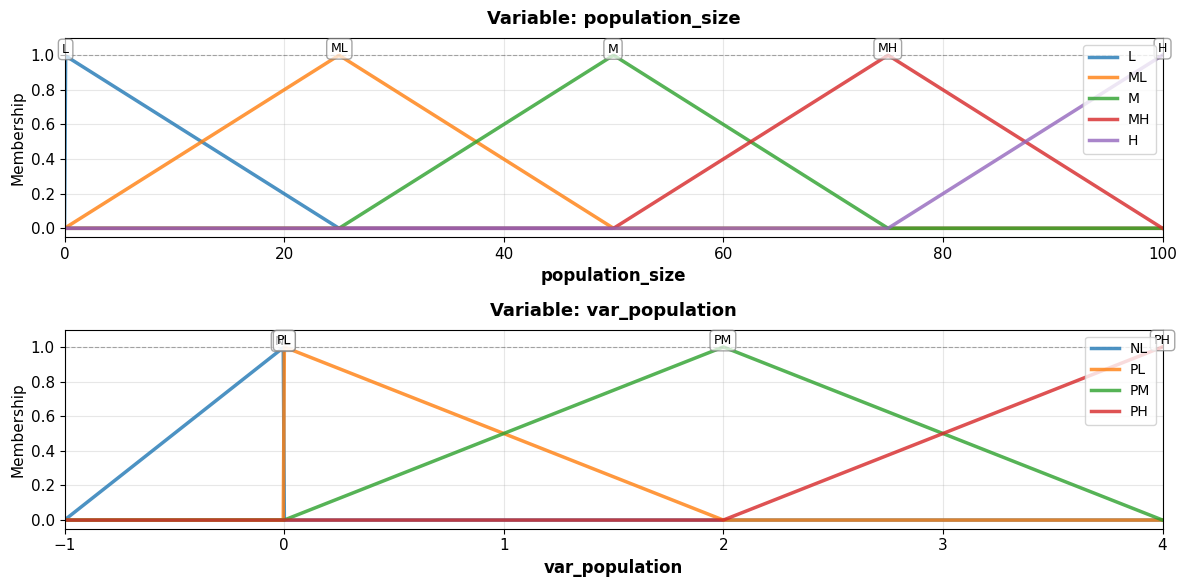

In [2]:
fis = MamdaniSystem(name="Population Dynamics")

# Input: populatio size
fis.add_input('population_size', (0, 100))
fis.add_term('population_size','L','triangular',[0,0,25])
fis.add_term('population_size','ML','triangular',[0,25,50])
fis.add_term('population_size','M','triangular',[25,50,75])
fis.add_term('population_size','MH','triangular',[50,75,100])
fis.add_term('population_size','H','triangular',[75,100,100])

# Output: variation of population
fis.add_output('var_population', (-1, 4))
fis.add_term('var_population', 'NL', 'triangular', (-1, 0, 0))
fis.add_term('var_population', 'PL', 'triangular', (0, 0, 2))
fis.add_term('var_population', 'PM', 'triangular', (0, 2, 4))
fis.add_term('var_population', 'PH', 'triangular', (2, 4, 4))

# Rules (sintaxe de tupla plana)
fis.add_rules([
    ('L', 'PL'),
    ('ML', 'PM'),
    ('M', 'PH'),
    ('MH', 'PL'),
    ('H', 'NL'),
])

fis.plot_variables()

In [ ]:
def my_dynamics_discrete(state, output_fis):
    """Simple and intuitive function for discrete dynamics

    Implements the difference equation: x_{n+1} = x_n + 0.05 * x_n * f(x_n)
    where f(x_n) is the fuzzy inference system output

    Args:
        state: Current state [x_n]
        output_fis: Fuzzy system output (population variation)

    Returns:
        Next state [x_{n+1}]
    """
    x = state[0]
    dx =  output_fis[0]
    return [x + 0.05*x*dx]

def my_dynamics_continuous(state, output_fis):
    """Simple and intuitive function for continuous dynamics

    Implements the differential equation: dx/dt = 0.05 * x * f(x)
    where f(x) is the fuzzy inference system output

    Args:
        state: Current state [x]
        output_fis: Fuzzy system output (population variation)

    Returns:
        Derivative [dx/dt]
    """
    x = state[0]
    dx =  output_fis[0]
    return [0.05*x*dx]

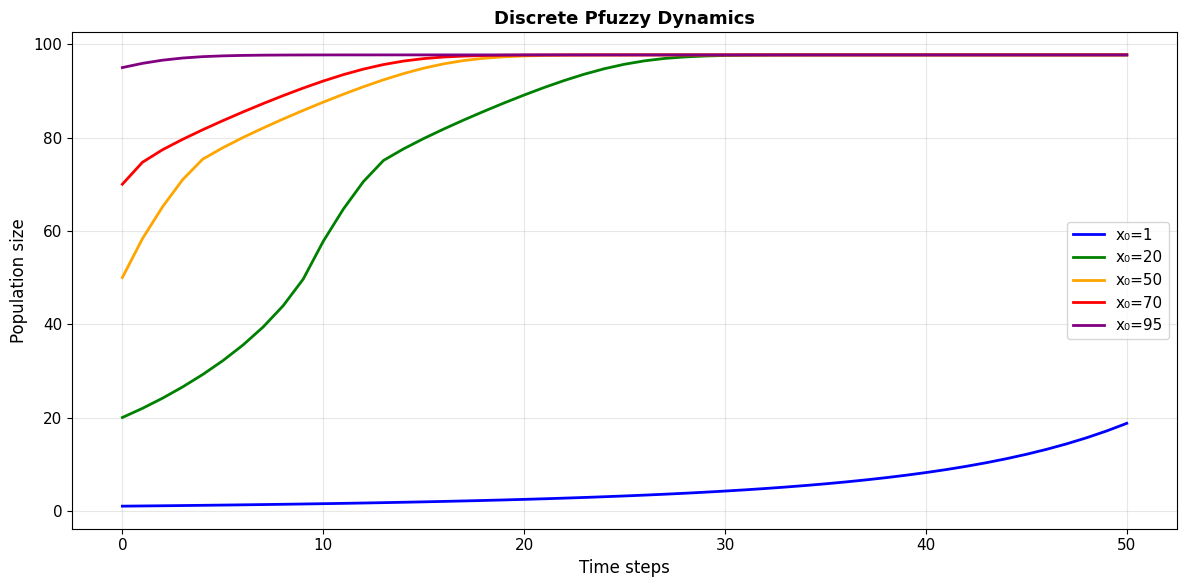

In [10]:
pfuzzy = PFuzzyDiscrete(fis=fis, dynamic_function=my_dynamics_discrete,mode='custom')

# Diferentes condições iniciais
initial_conditions = [1, 20, 50, 70, 95]
colors = ['blue', 'green', 'orange', 'red', 'purple']

fig, ax = plt.subplots(figsize=(12, 6))

for x0, color in zip(initial_conditions, colors):
    t,traj = pfuzzy.simulate(x0={'population_size': x0}, n_steps=50)
    ax.plot(t, traj[:, 0], color=color, linewidth=2, label=f'x₀={x0}')

ax.set_xlabel('Time steps', fontsize=12)
ax.set_ylabel('Population size', fontsize=12)
ax.set_title('Discrete Pfuzzy Dynamics', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

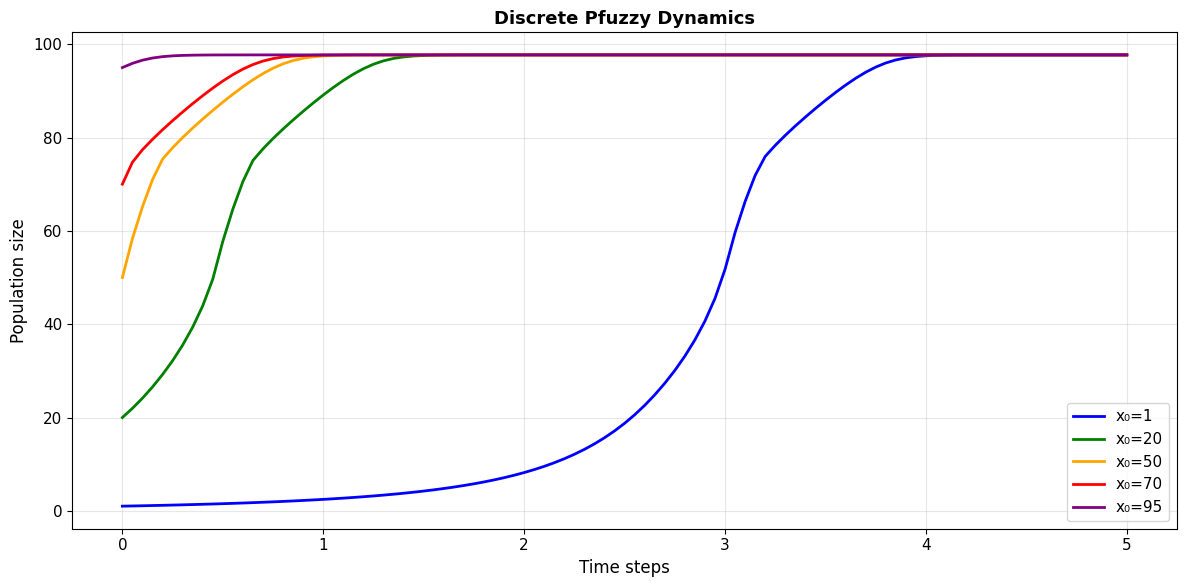

In [13]:
pfuzzy = PFuzzyContinuous(fis=fis, dynamic_function=my_dynamics_continuous,mode='custom')

# Diferentes condições iniciais
initial_conditions = [1, 20, 50, 70, 95]
colors = ['blue', 'green', 'orange', 'red', 'purple']

fig, ax = plt.subplots(figsize=(12, 6))

for x0, color in zip(initial_conditions, colors):
    t,traj = pfuzzy.simulate(x0={'population_size': x0},t_span=(0,5))
    ax.plot(t, traj[:, 0], color=color, linewidth=2, label=f'x₀={x0}')

ax.set_xlabel('Time steps', fontsize=12)
ax.set_ylabel('Population size', fontsize=12)
ax.set_title('Discrete Pfuzzy Dynamics', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Load dataset
iris = load_iris()

X = iris.data # Shape (150, 4) - 4 features
y = iris.target
y_binary = (y != 0).astype(int)  # 0 = Setosa, 1 = Não-Setosa


feature_names = iris.feature_names 
class_names = iris.target_names

# Create DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = iris.target_names[y]

print('📊 Iris dataset loaded!')
print(f'\nShape: {X.shape}')
print(f'\nClasses: {iris.target_names}')
print(f'\nFeatures: {iris.feature_names}')
df.head()

In [ ]:
# Visualize feature distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(iris.feature_names):
    for species_id, species_name in enumerate(iris.target_names):
        data = df[df['species'] == species_name][feature]
        axes[idx].hist(data, alpha=0.6, bins=15, label=species_name)
    
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution: {feature}', fontsize=12, weight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
X = X[:,2:4]
feature_names = ['Petal Length (cm)', 'Petal Width (cm)']
class_names = ['setosa', 'versicolor', 'virginica']


#Visualize separability
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red', 'blue']
labels = ['Setosa', 'Non-Setosa']

for class_id in [0, 1]:
    mask = y_binary == class_id
    ax.scatter(X[mask, -2], X[mask, -1], 
              c=colors[class_id], label=labels[class_id],
              s=80, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel(iris.feature_names[-2] + ' (cm)', fontsize=13)
ax.set_ylabel(iris.feature_names[-1] + ' (cm)', fontsize=13)
ax.set_title('Iris Dataset - 2 Features (Petal)', fontsize=15, weight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Note: Setosa is clearly separable from other classes!')

In [ ]:
# Example 2: Classification
print("\n" + "="*70)
print("EXAMPLE 2: CLASSIFICATION")
print("="*70)


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)


for i in range(X_train.shape[1]):
    print(f'Feature {i+1} - Train: [{X_train_norm[:, i].min():.2f}, {X_train_norm[:, i].max():.2f}] | '
          f'Validation: [{X_val_norm[:, i].min():.2f}, {X_val_norm[:, i].max():.2f}] | '
          f'Test: [{X_test_norm[:, i].min():.2f}, {X_test_norm[:, i].max():.2f}]')

In [ ]:
# Create and train model for classification
num_inputs = len(X_train_norm[0,:])
input_ranges = [[X_train_norm[:, idx].min(), X_train_norm[:, idx].max()] for idx in range(num_inputs)]

model_cls = ANFIS(n_inputs=num_inputs, 
                    n_mfs=[3]*num_inputs, 
                    mf_type='gaussmf',
                    input_ranges=input_ranges,
                    classification=True, 
                    learning_rate=5e-1,
                    lambda_l2=0.001, 
                    batch_size=128,
                    use_adaptive_lr=True)

# model_cls.fit(X_train_norm, 
#                 y_train, 
#                 epochs=500, 
#                 verbose=True,
#                 X_val=X_val_norm, 
#                 y_val=y_val, 
#                 early_stopping_patience=100)

model_cls.fit_metaheuristic(
    X_train_norm, y_train,
    optimizer='pso',
    n_particles=100,
    n_iterations=500,
    X_val=X_val_norm,
    y_val=y_val,
    verbose=True,
    )



In [ ]:
model_cls.fit(X_train_norm, 
                y_train, 
                epochs=500, 
                verbose=True,
                X_val=X_val_norm, 
                y_val=y_val, 
                early_stopping_patience=100)

In [ ]:
# Evaluate
y_pred_ = model_cls.predict(X_test_norm)
print(classification_report(y_test, y_pred_, target_names=labels))
cm= confusion_matrix(y_test, y_pred_)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap=plt.cm.Blues)


In [ ]:
fg = model_cls.plot_membership_functions()

In [ ]:
fg = model_cls.plot_metrics()

In [ ]:
fg = model_cls.plot_regularization()

In [ ]:
df = model_cls.rules_to_dataframe()
df

In [ ]:
fg = model_cls.show_rules_table()

In [ ]:
hist = model_cls.metaheuristic_history['convergence']
pd.DataFrame(hist)